In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data Exploration
By DataWhale

**INITIAL NOTES**
- Remove flights that have a different actual route than the planned route as training on these would just distort the model

## Sample Submission Format

In [3]:
sample_submission = pd.read_csv('data/sample_submission.csv')
sample_submission.head()

,FlightID,TeledyneRampWeight
0,181257208,67480.0
1,181195213,58882.0
2,181128045,66102.0
3,178889497,53966.0
4,178957284,55592.0


## Training Dataset

**NOTE:** `train_extended.csv` is the same as `train.csv` just with extra variables so no merging needs to be done.<br>

The train set contains over 765K flights from Ryanair in Europe between Nov 1st 2019 and 
March 31st 2022. These have been sampled at random from the whole dataset received 
from Ryanair.

**Target**<br>
The target variable is `TeledyneRampWeight` (actual weight on ramp before push back). 
This is generally measured by sensors on the wheels once the flight is fully loaded and just 
before the plane starts to taxi towards the take-off track.

**Variables known before prediction**<br> 
The predictor variables are those that the company knows before the prediction is needed. 
For this reason, the test set contains only these values, to ensure that the models built can 
be fed with information available at the moment the prediction is needed. Although 
formally we are predicting ramp weight, the main use is to predict how much fuel needs to 
be loaded into the airplane depending on the route, aircraft  and number of passengers (and 
possibly other factors). The complete list of predictor variables is: 
 
- `FlightID` - a unique identifier for every row (i.e. every specific flight)
- `FlightNumber` - the general number that identifies carrier and route. 
- `AircraftRegistration` - identifies the aircraft, like a plate number. 
- `AircraftCapacity` - number of available seats in the aircraft 
- `AircraftTypeGroup` - specifies the aircraft type and model 
- `ServiceDescription` - type of service (mostly scheduled flights, some charter flights) 
- `Carrier` - IATA Carrier Code 
- `AOCDescription` - aircraft operator 
- `ScheduledRoute` - route the flight is supposed to take 
- `DepartureScheduled` - Scheduled departure time (datetime) 
- `ArrivalScheduled` - Scheduled arrival time (datetime) 
- `BlockTimeScheduled` - Scheduled flight duration, including taxi times (minutes) 
- `Adults` - number of adults (>12) on board  
- `Children` - number of children (2-12) on board 
- `Freight` - Weight of Cargo carried by the aircraft (in Kg) 
- `Infants` - number of infants (0-2) on board. 
- `Bags` - Number of checked-in bags

**Variables known after prediction**<br> 
Other variables have been registered after each flight has been completed. These are 
included only in the train_extended.csv dataset. They can be used to derive intermediate 
models for the regression task, or for the open-ended objectives of the competition, but as 
it is obvious, these data will not be available when the decision on how much fuel to load 
needs to be taken. These variables report information relative to the flight once it has been 
completed: 
 
- `DepartureActual` - The actual departure time of the flight (datetime) 
- `ArrivalActual` - The actual arrival time of the flight (datetime) 
- `ActualRoute` - route the flight actually took (could be different in case of diversions) 
- `BlockTime` - The time difference between the above two (in minutes): includes time in the air plus the Taxi Out at departure and Taxi In at destination. 
- `TaxiOut` - Time in minutes to taxi from the terminal to take-off track  
- `FlightTime` - Time in minutes from take-off to landing 
- `Burnoff` - Fuel burned (in kg)  from departure to arrival terminal.

**Estimations from Ryanair models**<br> 
Finally, Ryanair is providing estimates from three of their own models. Since these models 
are used mostly to decide how much fuel to load, including these variables in the dataset 
would have turned the problem to be too simple (and somewhat circular). However, we give 
these values on the train_extended dataset since they can be used in many useful 
ways. These variables are: 
 
- `PlannedTOW` - Planned Take-Off-Weight. An internal Ryanair model to predict the TOW 
weight (which differs from the target variable because some fuel needs to be burned during 
TaxiOut). This model is used to calculate how much fuel needs to be loaded, depending on 
the route and number of passengers. 
- `PlannedTripTime` - A prediction of flight time by Ryanair model. 
- `PlannedZeroFuelWeight` - A prediction the weight of the aircraft, passengers and 
cargo with no fuel.  

In [3]:
train = pd.read_csv('data/train.csv')
train.head()

,FlightID,FlightNumber,AircraftRegistration,AircraftCapacity,AircraftTypeGroup,ServiceDescription,Carrier,AOCDescription,ScheduledRoute,DepartureScheduled,ArrivalScheduled,BlockTimeScheduled,Adults,Children,Freight,Infants,Bags,TeledyneRampWeight
0,181142302,221,SPRZK,197.0,Max,Scheduled Flight,FR,Ryanair Sun,EMA-BUD,2022-01-24 09:55:00,2022-01-24 12:30:00,155.0,112.0,6.0,0.0,2.0,43.0,62075.0
1,178908306,3373,9HQEC,189.0,NG,Scheduled Flight,FR,Malta Air,TRN-MLA,2020-03-09 09:00:00,2020-03-09 11:00:00,120.0,18.0,0.0,0.0,0.0,7.0,62002.0
2,178886981,2814,9HQCN,189.0,NG,Scheduled Flight,FR,Malta Air,STN-CGN,2020-01-06 07:35:00,2020-01-06 08:50:00,75.0,126.0,5.0,0.0,0.0,19.0,58029.0
3,180538798,6893,SPRKP,189.0,NG,Scheduled Flight,FR,Ryanair Sun,DTM-KTW,2020-12-11 07:15:00,2020-12-11 08:45:00,90.0,84.0,5.0,0.0,1.0,8.0,56070.0
4,178863684,2156,EIDWJ,189.0,NG,Scheduled Flight,FR,Ryanair DAC,BHX-AGP,2020-02-07 15:20:00,2020-02-07 18:05:00,165.0,175.0,2.0,0.0,0.0,47.0,68315.0


In [4]:
train_extended = pd.read_csv('data/train_extended.csv')
train_extended.head()

,FlightID,FlightNumber,AircraftRegistration,AircraftCapacity,AircraftTypeGroup,ServiceDescription,Carrier,AOCDescription,ScheduledRoute,ActualRoute,...,Adults,Children,Freight,Infants,Bags,FlightTime,PlannedZeroFuelWeight,PlannedTOW,PlannedTripTime,TeledyneRampWeight
0,181142302,221,SPRZK,197.0,Max,Scheduled Flight,FR,Ryanair Sun,EMA-BUD,EMA-BUD,...,112.0,6.0,0.0,2.0,43.0,137.0,56242.0,62723.0,8246.0,62075.0
1,178908306,3373,9HQEC,189.0,NG,Scheduled Flight,FR,Malta Air,TRN-MLA,TRN-MLA,...,18.0,0.0,0.0,0.0,7.0,102.0,57148.0,63878.0,6227.0,62002.0
2,178886981,2814,9HQCN,189.0,NG,Scheduled Flight,FR,Malta Air,STN-CGN,STN-CGN,...,126.0,5.0,0.0,0.0,19.0,50.0,53620.0,58089.0,3653.0,58029.0
3,180538798,6893,SPRKP,189.0,NG,Scheduled Flight,FR,Ryanair Sun,DTM-KTW,DTM-KTW,...,84.0,5.0,0.0,1.0,8.0,71.0,53396.0,58999.0,4784.0,56070.0
4,178863684,2156,EIDWJ,189.0,NG,Scheduled Flight,FR,Ryanair DAC,BHX-AGP,BHX-AGP,...,175.0,2.0,0.0,0.0,47.0,155.0,59199.0,68573.0,9275.0,68315.0


### Basic Checks

In [5]:
len(train) == len(train_extended)

True

Duplicates

In [6]:
train.duplicated().sum()

0

In [7]:
train_extended.duplicated().sum()

0

Missing values

In [8]:
train.isna().sum().sum()

0

In [9]:
train_extended.isna().sum().sum()

0

In [20]:
# Storing all the numerical and categorical columns separately in a list 
num_cols = [col for col in train.columns if train[col].dtype != "O"]
cat_cols = [col for col in train.columns if train[col].dtype == "O"]

In [26]:
train[num_cols[2:]].describe().round().transpose()

,count,mean,std,min,25%,50%,75%,max
AircraftCapacity,765236.0,189.0,2.0,148.0,189.0,189.0,189.0,197.0
BlockTimeScheduled,765236.0,135.0,49.0,25.0,95.0,130.0,165.0,355.0
Adults,765236.0,123.0,43.0,0.0,95.0,136.0,159.0,212.0
Children,765236.0,7.0,7.0,0.0,2.0,5.0,9.0,139.0
Freight,765236.0,41.0,25440.0,0.0,0.0,0.0,0.0,22233333.0
Infants,765236.0,1.0,1.0,0.0,0.0,1.0,2.0,40.0
Bags,765236.0,37.0,25.0,1.0,20.0,32.0,49.0,1170.0
TeledyneRampWeight,765236.0,61993.0,5667.0,360.0,58846.0,62437.0,65104.0,163800.0


In [68]:
train[train["TeledyneRampWeight"] ==train["TeledyneRampWeight"].max()]
#["AircraftTypeGroup"].value_counts()

,FlightID,FlightNumber,AircraftRegistration,AircraftCapacity,AircraftTypeGroup,ServiceDescription,Carrier,AOCDescription,ScheduledRoute,DepartureScheduled,ArrivalScheduled,BlockTimeScheduled,Adults,Children,Freight,Infants,Bags,TeledyneRampWeight
248,178931466,4214,9HQCT,189.0,NG,Scheduled Flight,FR,Malta Air,BGY-BRQ,2020-01-15 10:05:00,2020-01-15 11:30:00,85.0,72.0,2.0,0.0,0.0,18.0,163800.0
6068,180380028,7748,9HQDN,189.0,NG,Scheduled Flight,FR,Malta Air,BGY-CAG,2020-09-15 19:35:00,2020-09-15 21:10:00,95.0,47.0,0.0,0.0,2.0,12.0,163800.0
7366,179081460,9994,EIDLE,189.0,NG,Scheduled Flight,FR,Ryanair DAC,PSA-PMO,2019-11-05 21:20:00,2019-11-05 22:45:00,85.0,161.0,7.0,0.0,1.0,25.0,163800.0
8415,179049392,8519,9HQAG,189.0,NG,Scheduled Flight,FR,Malta Air,BGY-CGN,2019-11-24 14:30:00,2019-11-24 16:00:00,90.0,179.0,2.0,0.0,0.0,55.0,163800.0
10908,179011468,7075,9HQEI,189.0,NG,Scheduled Flight,FR,Malta Air,FCO-BRI,2020-02-26 18:55:00,2020-02-26 20:00:00,65.0,85.0,4.0,0.0,0.0,5.0,163800.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
760361,178795612,303,9HQAG,189.0,NG,Scheduled Flight,FR,Malta Air,LPA-CGN,2019-11-23 19:45:00,2019-11-24 00:20:00,275.0,174.0,6.0,0.0,0.0,120.0,163800.0
761386,180707824,194,EIEFD,189.0,NG,Scheduled Flight,FR,Ryanair DAC,STN-BLQ,2021-10-26 06:00:00,2021-10-26 07:55:00,115.0,128.0,14.0,0.0,0.0,39.0,163800.0
762492,179013210,7127,EIGDD,189.0,NG,Scheduled Flight,FR,Ryanair DAC,LPA-DUB,2020-01-07 19:05:00,2020-01-07 23:30:00,265.0,165.0,23.0,0.0,0.0,148.0,163800.0
763918,181248784,3745,9HQAT,189.0,NG,Scheduled Flight,FR,Malta Air,CRL-PSA,2021-11-28 17:00:00,2021-11-28 18:40:00,100.0,133.0,4.0,0.0,0.0,18.0,163800.0


In [81]:
unique_ramp_weights = train["TeledyneRampWeight"].unique()
unique_ramp_weights[np.argsort(unique_ramp_weights)][-10:]

array([159400., 159640., 159800., 159960., 160800., 161400., 162720.,
       162840., 163200., 163800.])

In [50]:
# Unique cases where the Ramp weight is less than the freight 
train[train[num_cols[2:]].max(axis=1) != train["TeledyneRampWeight"]]

,FlightID,FlightNumber,AircraftRegistration,AircraftCapacity,AircraftTypeGroup,ServiceDescription,Carrier,AOCDescription,ScheduledRoute,DepartureScheduled,ArrivalScheduled,BlockTimeScheduled,Adults,Children,Freight,Infants,Bags,TeledyneRampWeight
16403,180355951,9215,9HLOZ,180.0,Airbus,Scheduled Flight,FR,Lauda Motion Europe,VIE-MXP,2020-10-16 16:45:00,2020-10-16 18:20:00,95.0,127.0,1.0,93208.0,0.0,16.0,59729.0
118985,178774477,42,9HQEM,189.0,NG,Scheduled Flight,FR,Malta Air,TXL-LUX,2020-02-23 09:10:00,2020-02-23 10:40:00,90.0,148.0,14.0,939393.0,3.0,25.0,61585.0
209683,179858117,2014,SPRKU,189.0,NG,Scheduled Flight,FR,Ryanair Sun,PRG-STN,2020-07-14 09:55:00,2020-07-14 11:50:00,115.0,77.0,3.0,66990.0,0.0,34.0,56107.0
292872,179778928,605,SPRSC,189.0,NG,Scheduled Flight,FR,Ryanair Sun,BUD-CPH,2020-08-07 17:35:00,2020-08-07 19:30:00,115.0,119.0,8.0,66990.0,0.0,29.0,60406.0
381190,180182762,8229,SPRSO,189.0,NG,Scheduled Flight,FR,Ryanair Sun,MRS-PRG,2020-07-17 13:15:00,2020-07-17 15:05:00,110.0,98.0,6.0,77990.0,0.0,23.0,58900.0
565628,178819695,1087,EIDPZ,189.0,NG,Scheduled Flight,FR,Ryanair DAC,BLQ-CTA,2019-11-03 19:00:00,2019-11-03 20:40:00,100.0,173.0,6.0,22233333.0,1.0,41.0,64995.0
575073,179745036,129,EIEVA,189.0,NG,Scheduled Flight,FR,Ryanair DAC,HAM-BCN,2020-09-10 13:30:00,2020-09-10 16:05:00,155.0,72.0,0.0,62286.0,0.0,22.0,58229.0
760437,179077789,9882,SPRSE,189.0,NG,Scheduled Flight,FR,Ryanair Sun,WRO-ALC,2019-12-21 15:35:00,2019-12-21 18:40:00,185.0,171.0,11.0,69990.0,5.0,109.0,68605.0


Basic Analysis  
- the 75% quantile for freight is 0 yet its maximum value is 22,233,333 Kg which seems to be an exceptionally large value.  
- On closer analysis, we found 8 records where the Ramp Weight was smaller than the freight value. 
    - CONCLUSION: DROP THESE RECORDS    
- 281 records have the maximum ramp value of 163,800 
    - All of them belong to the NG aircraft type with carrier = FR
    - Service Description is majorly Scheduled Flight  
    - All of them have the same max capacity of 189   
    - 

Data types
- Dates need to be converted from object to datetime

In [10]:
train_extended.dtypes

FlightID                   int64
FlightNumber               int64
AircraftRegistration      object
AircraftCapacity         float64
AircraftTypeGroup         object
ServiceDescription        object
Carrier                   object
AOCDescription            object
ScheduledRoute            object
ActualRoute               object
DepartureScheduled        object
ArrivalScheduled          object
DepartureActual           object
ArrivalActual             object
BlockTimeScheduled       float64
BlockTime                float64
TaxiOut                  float64
Burnoff                  float64
Adults                   float64
Children                 float64
Freight                  float64
Infants                  float64
Bags                     float64
FlightTime               float64
PlannedZeroFuelWeight    float64
PlannedTOW               float64
PlannedTripTime          float64
TeledyneRampWeight       float64
dtype: object

### Basic EDA

#### Target
- Seems like there are some outliers and extreme values

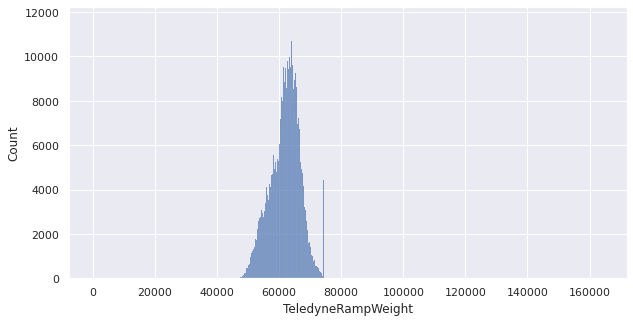

In [11]:
sns.set()
fig, ax = plt.subplots(1,1,figsize=(10,5))
sns.histplot(train.TeledyneRampWeight);

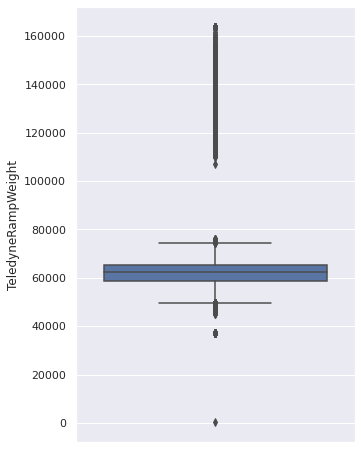

In [12]:
sns.set()
fig, ax = plt.subplots(1,1,figsize=(5,8))
sns.boxplot(data=train, y='TeledyneRampWeight');

#### Correlations

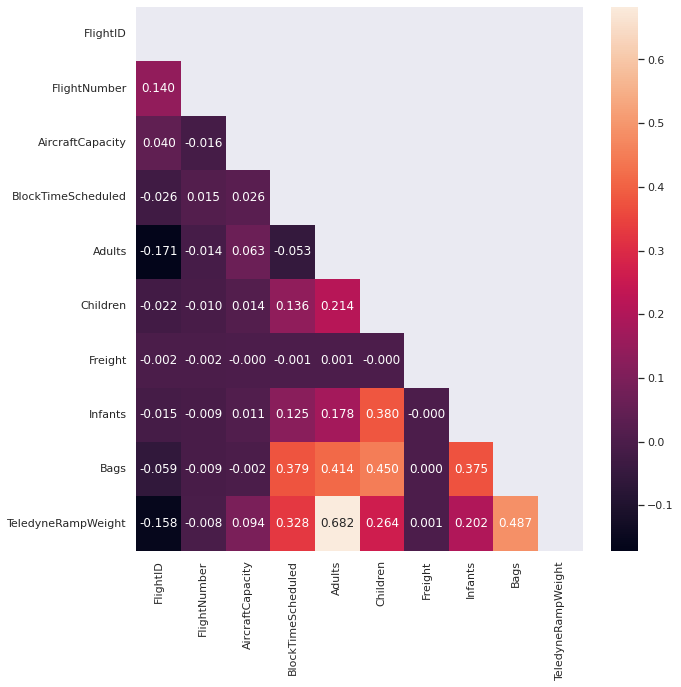

In [16]:
train_corr = train.corr(numeric_only=True)
matrix = np.triu(train_corr)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(train_corr,annot=True,mask=matrix, fmt = '.3f');